# Name : Tharindu O.K.D {-}
# Index No. : 190622R {-}

### Question 01 {-}

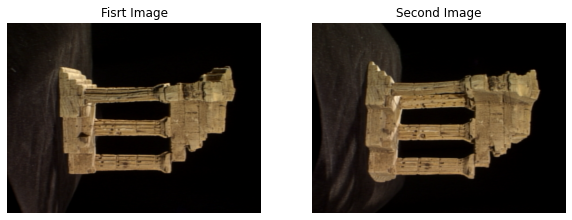

In [122]:
import numpy as np
import cv2 as cv
import matplotlib.pyplot as plt
f = open(r'templeSR_par.txt', 'r')
assert f is not None
n = int(f.readline())

# first image
l = f.readline().split()
im1_fn = l[0]
K1 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R1 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t1 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# second image
l = f.readline().split()
im2_fn = l[0]
K2 = np.array([float(i) for i in l[1:10]]).reshape((3,3))
R2 = np.array([float(i) for i in l[10:19]]).reshape((3,3))
t2 = np.array([float(i) for i in l[19:22]]).reshape((3,1))

# read the two images
img1 = cv.imread(im1_fn, cv.IMREAD_COLOR)
img2 = cv.imread(im2_fn, cv.IMREAD_COLOR)
assert img1 is not None
assert img2 is not None
fig, ax = plt.subplots(1, 2, figsize=(10, 10))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].axis('off')
ax[0].set_title("Fisrt Image")
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].axis('off')
ax[1].set_title("Second Image")
plt.show()
 

### Question 02 {-}

In [123]:
# Compute the camera matrices

P1 = K1 @ np.hstack((R1, t1))
P2 = K2 @ np.hstack((R2, t2))

### Question 03 {-}

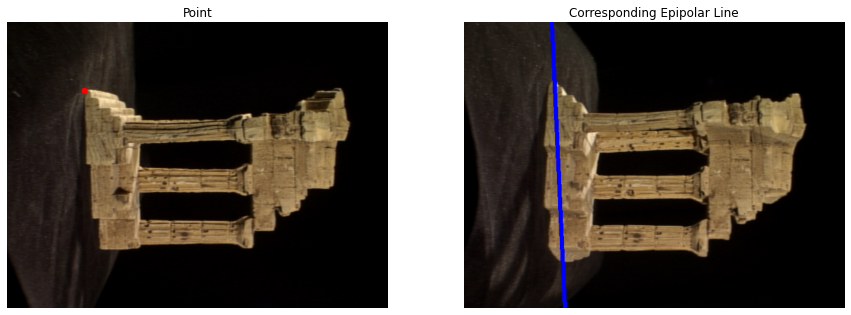

In [128]:
from scipy.linalg import null_space

def skew(x):
    x = x.ravel()
    return np.array([[0, -x[2], x[1]], [x[2], 0, -x[0]], [-x[1], x[0], 0]])

C = null_space(P1)
C = C * np.sign(C[0, 0])
e2 = P2 @ C

e2x = skew(e2)

F = e2x @ P2 @ np.linalg.pinv(P1)

x = np.array([130, 115, 1])
cv.circle(img1, (x[0], x[1]), 5, (0, 0, 255), -1)
l2 = F @ x.T
p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int)
p2 = np.array([500, (l2[0]*500 + l2[2])/l2[1]]).astype(int)
cv.line(img2, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 0), 5)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(cv.cvtColor(img1, cv.COLOR_BGR2RGB))
ax[0].set_title("Point")
ax[0].axis("off")
ax[1].imshow(cv.cvtColor(img2, cv.COLOR_BGR2RGB))
ax[1].set_title("Corresponding Epipolar Line")
ax[1].axis("off")
plt.show()


### Question 04 {-}

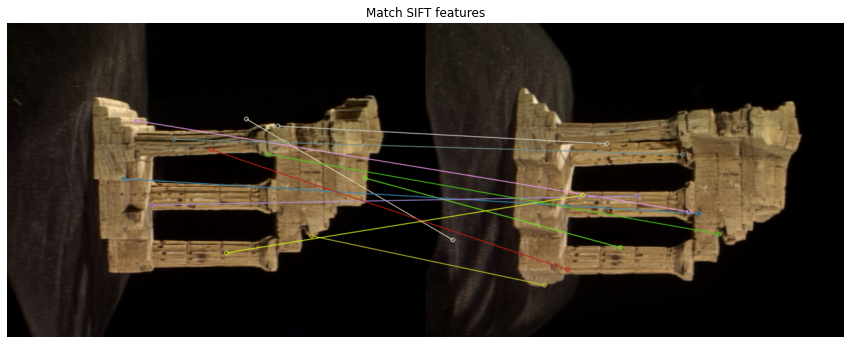

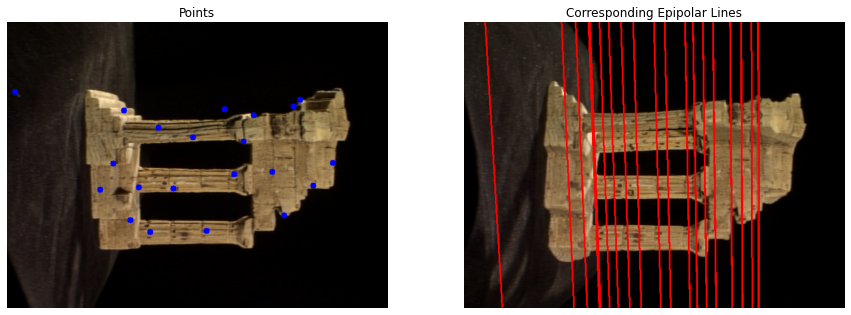

In [121]:
img1 = cv.imread(im1_fn)
img1 = cv.cvtColor(img1, cv.COLOR_BGR2RGB)
img2 = cv.imread(im2_fn)
img2 = cv.cvtColor(img2, cv.COLOR_BGR2RGB)


sift = cv.xfeatures2d.SIFT_create()

keypoints_1, descriptors_1 = sift.detectAndCompute(img1,None)
keypoints_2, descriptors_2 = sift.detectAndCompute(img2,None)
keypoints_1 = keypoints_1[::40]
keypoints_2 = keypoints_2[::40]
descriptors_1 = descriptors_1[::40]
descriptors_2 = descriptors_2[::40]


bf = cv.BFMatcher(cv.NORM_L1, crossCheck=True)

matches = bf.match(descriptors_1,descriptors_2)
matches = sorted(matches, key = lambda x:x.distance)

img3 = cv.drawMatches(img1, keypoints_1, img2, keypoints_2, matches[:150], img2, flags=2)

fig, ax = plt.subplots(figsize=(15,15))
ax.imshow(img3)
ax.set_title("Match SIFT features")
plt.axis("off")
plt.show()

points = np.array(cv.KeyPoint_convert(keypoints_1))
ones = np.ones((points.shape[0], 1))
points = np.concatenate((points, ones), axis=1).astype(int)


for point in points:
    cv.circle(img1, (point[0], point[1]), 5, (0, 0, 255), -1)
    l2 = F @ point.T
    p1 = np.array([0, (l2[0]*0 + l2[2])/l2[1]]).astype(int)
    p2 = np.array([500, (l2[0]*500 + l2[2])/l2[1]]).astype(int)
    cv.line(img2, (p1[0], p1[1]), (p2[0], p2[1]), (255, 0, 0), 2)

fig, ax = plt.subplots(1, 2, figsize=(15, 15))
ax[0].imshow(img1)
ax[0].set_title("Points")
ax[0].axis("off")
ax[1].imshow(img2)
ax[1].set_title("Corresponding Epipolar Lines")
ax[1].axis("off")
plt.show()

